I'm basing this notebook on the explanation of delta-sigma converters given at [this](https://www.beis.de/Elektronik/DeltaSigma/DeltaSigma.html) website. As discussed on the website, there is no real difference between a delta-sigma ADC and delta-sigma DAC, except whether the individual components of the modulator and low pass filter are digital or analog. This being python, I'll be creating a Delta-Sigma DDC (digital-digital), solely for the purpose of disecting and understanding how it works.

The basic scheme of a delta-sigma converter is as follows:

Signal in -> Delta-Sigma modulator -> Bitstream -> Low Pass filter -> Signal out

For an ADC, the signal in and delta-sigma modulator would be analog, and the low pass filter and signal out will be digital. For DACs, it would be the other way around. In either case, the bitstream is only contains high/low values. The  modulator, bistream, and low pass filter operate at a clock cycle much faster than the outside signal (64x or 128x the digital signal).

The modulator:

In [78]:
import numpy as np
import scipy as sp
from scipy import signal

upsample_rate = 128
max_time = 100
# The two frequencies of the signal
f1= .24
f2 = .64
# amplitudes. I'm making the signal range between -1 and 1
a1 = .71
a2 = 1 - a1

time = np.linspace(0,100, 100, endpoint=False)
series = a1 * np.sin(2*np.pi*f1*time) + a2 * np.sin(2*np.pi*f2*time)

bitstream = np.zeros(series.size*upsample_rate)
bitstream_time = np.linspace(0,max_time, 128*max_time, endpoint=False)


register = 0
bit_ddc = -1
count = 0
for signal_in in series:
    for i in range(upsample_rate):
        delta = signal_in - bit_ddc
        sigma = register + delta
        register = sigma
        bit_ddc = 1 if register > 0 else -1
        bitstream[count] = bit_ddc
        count +=1

# filter
sos = signal.butter(128,2/upsample_rate, 'low', output = 'sos')
filtered_signal = signal.sosfilt(sos,bitstream)

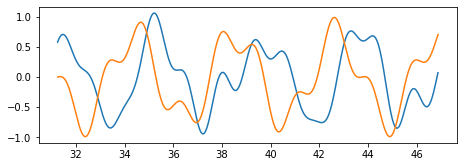

In [79]:
# plot true and delta-sigma
import matplotlib.pyplot as plt
t = np.linspace(0, max_time, 128*max_time)
y = a1 * np.sin(2*np.pi*f1*t) + a2 * np.sin(2*np.pi*f2*t)


plt.figure(figsize=(7.5,2.5))
plt.plot(bitstream_time[4000:6000], filtered_signal[4000:6000])
plt.plot(t[4000:6000],y[4000:6000])
# plt.plot(time[40:40], series[20:40])